# Modeling

## Introduction<a id='Introduction'></a>

This notebook will go through different models, plot confusion matrix, and gather scores to see what the best model is for prediction. 

## Table of Contents<a id='Table_of_Contents'></a>
* [Introduction](#Introduction)
* [Table of Contents](#Table_of_Contents)
* [Imports](#Imports)
* [Functions](#Functions)
* [View the Data](#View_Data)
* [Baseline Model](#Baseline_Model)
* [Modeling - Logistic Regression](#Modeling_LR)
* [Modeling - Random Forest](#Modeling_RF)
* [Conclusion](#Conclusion)

## Imports<a id='Imports'></a>

Here we will import all the necessary libraries that we will need in this notebook. We will also import the X_train, X_test, y_train, and y_test data from the previous notebook. 

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor

#Don't display future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set()

In [2]:
#Import cleaned data
X_train = pd.read_csv('data/clean_data/X_train.csv', index_col = 0)
X_test = pd.read_csv('data/clean_data/X_test.csv', index_col = 0)
y_train = pd.read_csv('data/clean_data/y_train.csv', index_col = 0)
y_test = pd.read_csv('data/clean_data/y_test.csv', index_col = 0)

## Functions <a id='Functions'></a>

Here we are defining the functions we will need in this notebook: Plotting a confusion matrix and scoring the models. 

For the scoring function, here are the scores that are calculated along with their definitions:

**Accuracy** - Calculates the overall correctness of a model using the ratio of correct predictions divided by the total number of predictions. 

    (true positive + true negative) / total predictions

**Precision** - Calculates the percentage of true positives out of all the total positive values found by the model. Divides the true positive values by the sum of the true positive and false positive values. 

    true positive / (true positive + false positive)

**Recall** - Calculates the percentage of true positives out of all the total positive values found in the actual data. Divides the true positive values by the sum of the true positive and false negative values. 

    true positive / (true positive + false negative)

**F1** - Combines the Precision and Recall scores by calculating 2 times the product of precision and recall, then dividing by the sum of precision and recall. 

    2 * (precision * recall) / (precision + recall)

**Balanced Accuracy** - Calculates the recall for each specific class individually and then averages it out. In this situation, there are only 2 classes, Common and Uncommon Diagnosis. 

    Recall(class 1) + Recall(class 2) ... + Recall(class n) / n

In [3]:
def plot_confusion_matrix(yactual, y_pred):
    '''This function plots a confusion matrix using actual data versus model predicted data. '''

    # Create confusion matrix
    cm = confusion_matrix(yactual, y_pred)
    
    # Calculate sum of all elements in the confusion matrix
    total = np.sum(cm)

    # Calculate percentages by dividing each element by the total sum
    cm_percentages = cm / total

    # Define color map
    cmap = plt.cm.Blues

    # Plot confusion matrix
    plt.imshow(cm_percentages, interpolation='nearest', cmap=cmap)
    plt.grid(False)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['uncommon', 'common']

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Add labels to each cell
    for i, j in itertools.product(range(cm_percentages.shape[0]), range(cm_percentages.shape[1])):
        cell_value = cm_percentages[i, j]
        cell_color = 'white' if cell_value < 0.3 else 'blue'  # Choose the background color based on the cell value
        text_color = 'black' if cell_color == 'white' else 'white'  # Choose the text color based on the background color
        plt.text(j, i, format(cell_value, '.2%'),
                 horizontalalignment="center",
                 color=text_color,
                 fontweight='bold', fontsize=12)  # Set the font weight and size

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [4]:
def Scores(true, pred):
    '''This function calculates and prints the accuracy, precision, recall, f1, and balanced accuracy.'''
    
    # Accuracy
    accuracy = accuracy_score(true, pred)

    # Precision
    precision = precision_score(true, pred)

    # Recall
    recall = recall_score(true, pred)

    # F1 Score
    f1 = f1_score(true, pred)

    # Balanced Accuracy
    balanced_accuracy = balanced_accuracy_score(true, pred)

    print('Accuracy: ' + str(round(accuracy, 3)))
    print('Precision: ' + str(round(precision, 3)))
    print('Recall: ' + str(round(recall, 3)))
    print('F1: ' + str(round(f1, 3)))
    print('Balanced Accuracy: ' + str(round(balanced_accuracy, 3)))

## View the Data<a id='View_Data'></a>

Let's view the data to get a sense of what we are currently working with for our models. We'll look at X_train, X_test, y_train and y_test. 

In [5]:
X_train

,Age,PSU,Weight,Sex_M,BodyPart_Ankle,"BodyPart_Arm, lower","BodyPart_Arm, upper",BodyPart_Ear,BodyPart_Elbow,BodyPart_Eyeball,...,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day,day_of_week
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
140248355,-0.670665,0.829478,1.357959,0,0,0,1,0,0,0,...,0,0,0,0,1,0,25,7,2013,3
131033338,-0.889547,0.024048,1.292006,1,0,0,0,0,0,0,...,0,0,0,0,1,0,5,10,2013,5
141120816,-1.035468,0.059067,1.161436,1,0,0,0,0,0,0,...,0,0,1,0,0,0,19,10,2014,6
150717427,-0.451783,0.654385,-0.554388,1,0,1,0,0,0,0,...,0,0,0,0,0,1,5,7,2015,6
130910795,-0.743625,-0.396176,-0.820458,0,0,0,0,0,0,0,...,0,0,0,0,0,0,31,8,2013,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150604252,-0.962507,-0.851419,-0.850115,0,0,0,0,0,0,0,...,0,1,0,0,0,0,24,5,2015,6
140443952,-0.889547,-0.361157,-0.848867,0,0,0,0,0,0,0,...,0,0,0,0,0,0,17,4,2014,3
140426349,2.831447,1.214684,-0.597344,0,0,0,0,0,0,0,...,0,0,0,0,0,1,8,4,2014,1


In [6]:
X_test

,Age,PSU,Weight,Sex_M,BodyPart_Ankle,"BodyPart_Arm, lower","BodyPart_Arm, upper",BodyPart_Ear,BodyPart_Elbow,BodyPart_Eyeball,...,Location_Street,Location_Unknown,Stratum_L,Stratum_M,Stratum_S,Stratum_V,Treatment_Day,Month_Day,Year_Day,day_of_week
CPSC_Case_Number,,,,,,,,,,,,,,,,,,,,,
170827787,-0.889547,1.669927,-0.876984,0,0,1,0,0,0,0,...,0,0,0,0,0,0,22,7,2017,5
160852455,-1.035468,-0.781382,-0.884344,1,0,0,0,0,0,0,...,0,0,0,0,0,0,14,8,2016,6
170157166,-0.816586,0.409254,1.533394,1,0,0,0,0,0,0,...,0,0,0,1,0,0,3,1,2017,1
141223560,-0.743625,0.514310,-0.557450,0,0,1,0,0,0,0,...,0,1,0,0,0,1,13,9,2014,5
130852418,3.852897,1.739965,1.357959,1,0,0,0,0,1,0,...,0,0,0,0,1,0,13,8,2013,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161044669,3.342172,1.704946,-0.544457,1,0,0,0,0,0,0,...,0,0,0,0,0,1,11,10,2016,1
130902754,2.101841,-0.746363,-0.581395,0,0,1,0,0,0,0,...,0,0,0,0,0,1,24,8,2013,5
171106994,0.204863,-0.676326,-0.518797,1,0,0,0,0,1,0,...,0,0,0,0,0,1,29,10,2017,6


In [7]:
y_train

,common
CPSC_Case_Number,
140248355,1
131033338,1
141120816,0
150717427,1
130910795,1
...,...
150604252,1
140443952,1
140426349,1


In [8]:
y_test

,common
CPSC_Case_Number,
170827787,1
160852455,0
170157166,0
141223560,1
130852418,0
...,...
161044669,1
130902754,0
171106994,1


We see that X_train and X_test are all the values we are using for our models and then y_train and y_test are the actual values for the Diagnosis that we can compare our results to with for whether we got our predictions correct or not. Let's make sure everything is a numerical value as well. 

In [9]:
X_train.dtypes

Age               float64
PSU               float64
Weight            float64
Sex_M               int64
BodyPart_Ankle      int64
                   ...   
Stratum_V           int64
Treatment_Day       int64
Month_Day           int64
Year_Day            int64
day_of_week         int64
Length: 102, dtype: object

In [10]:
X_test.dtypes

Age               float64
PSU               float64
Weight            float64
Sex_M               int64
BodyPart_Ankle      int64
                   ...   
Stratum_V           int64
Treatment_Day       int64
Month_Day           int64
Year_Day            int64
day_of_week         int64
Length: 102, dtype: object

In [11]:
y_train.dtypes

common    int64
dtype: object

In [12]:
y_test.dtypes

common    int64
dtype: object

It appears that everything is either an int or a float so everything should be ready to go for our models. 

## Baseline Model<a id='Baseline_Model'></a>

Before we create a model, let's get a baseline down of what we would expect out of each Diagnosis by taking the mean value of the training set and get the percentage of what each Diagnosis would be. 

In [13]:
train_percent = np.mean(y_train)
train_percent_df = pd.DataFrame(train_percent,columns=['Percentage'])
train_percent_df

,Percentage
common,0.562559


We see that the "Common" diagnosis makes up on average 56.26% of the cases in the training set. This shows the breakdown of what we would expect out of each Diagnosis given the training data. We can then predict this value for everything in the test set to get a baseline for what just guessing the most common diagnosis would be. 

In [14]:
#Saving the column values so we can identify each column later on. 
diagnosis = y_train.columns 

#Get the values ready for the regressor
y_train = np.ravel(y_train)
y_test_index = y_test.index
y_test = np.ravel(y_test)

Now we can setup a DummyRegressor using the mean and fit it with X_train and y_train. We can then predict using the train and test data to see how our results compare. 

In [15]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_pred_train = dumb_reg.predict(X_train)
dumb_pred_test = dumb_reg.predict(X_test)

In [16]:
dumb_pred_train = np.ceil(dumb_pred_train).astype(int)
dumb_pred_test = np.ceil(dumb_pred_test).astype(int)

Now let's plot the confusion matrix for the training data predictions. 

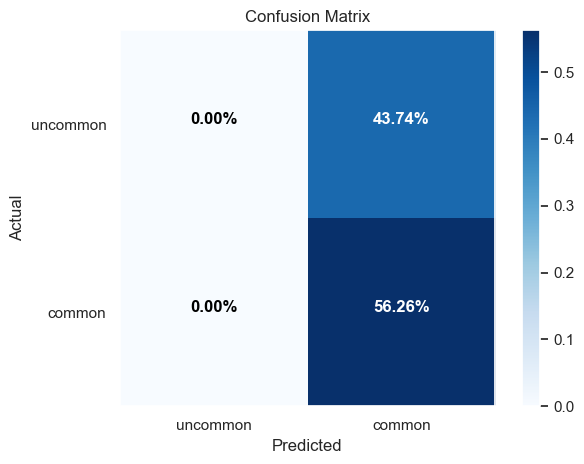

In [17]:
plot_confusion_matrix(y_train, dumb_pred_train)

We see that 56.26% of the data was predicted corrected as the common diagnosis which matches what the mean of the train data was for the common diagnosis type. Let's see how it scored.

In [18]:
Scores(y_train,dumb_pred_train)

Accuracy: 0.563
Precision: 0.563
Recall: 1.0
F1: 0.72
Balanced Accuracy: 0.5


Since there were no False negatives (predicted uncommon but it was actually a common), we get a recall of 100%. However, the accuracy, precision, and Balanced accuracy were all low in the 50%s. The F1 score is inflated by the high Recall score which is why that appears as  high outlier. Let's now look at the test data with the dummy regressor. 

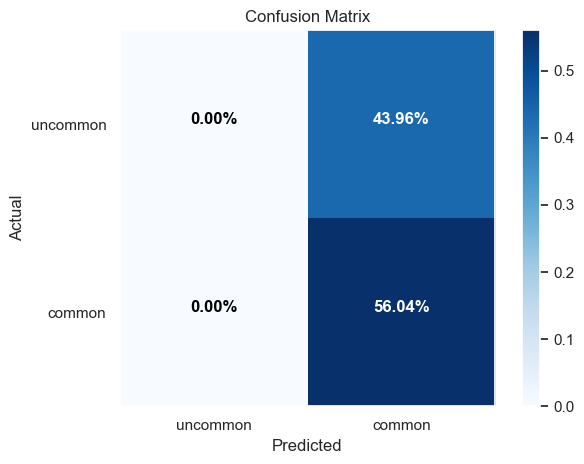

In [19]:
plot_confusion_matrix(y_test, dumb_pred_test)

We see that with the unseen test data, it falls pretty close to the actual mean still, with a total correctness of 56.04% for predicting common values. This sets the bar for the minimum a model can predict to make it more useful than just guessing the mean. 

In [20]:
Scores(y_test,dumb_pred_test)

Accuracy: 0.56
Precision: 0.56
Recall: 1.0
F1: 0.718
Balanced Accuracy: 0.5


For the scoring, we see similar results to the train data. A perfect Recall due to no False negatives, as well as an inflated F1 score because of the high Recall. The rest of the scores for Accuracy, Precision, and Balanced Accuracy were in the 50's so that is our baseline when comparing the models. 

## Modeling - Logistic Regression<a id='Modeling_LR'></a>

Now let's test a model. We will start with Logistic Regression and can then compare it to the baseline model to see how it performs. We will first find the best C parameter, then fit on the train data, then predict on the train and test data separtely to see how the model performs. 

In [21]:
c_values = [0.01, 1, 10, 100,1000]
accuracy_scores = []
for C in c_values:
    logreg = LogisticRegression(max_iter=10000, C=C)
    logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
# Find the index of the C value with the highest accuracy
best_index = accuracy_scores.index(max(accuracy_scores))
best_C = c_values[best_index]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best C:", best_C)
print("Accuracy:", accuracy)

Best C: 100
Accuracy: 0.7532270311313591


We found the best C value to be 100 so we will use that in our Logistic Regression model. Let's fit the data and predict on the train and test sets. 

In [22]:
logreg = LogisticRegression(max_iter=10000, C=100)
logreg.fit(X_train,y_train)

y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)

#Way to view the results of the predictions via case number
#(pd.DataFrame(y_pred_test, columns= diagnosis, index=y_test_index)) 

Now that we have our predicted values, let's plot a confusion matrix with the training data to see how the model did with it. 

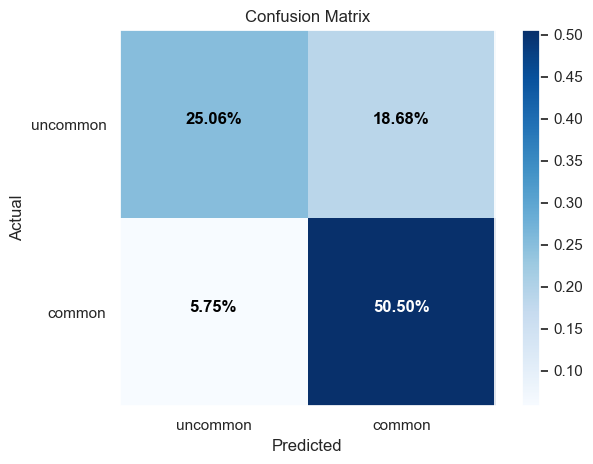

In [23]:
plot_confusion_matrix(y_train, y_pred_train)

The Logistic Regresion model correctly predicted  a total of 75.68% of the train data when it was fed back into it (50.73% of the data is a common diagnosis and 24.95% is an uncommon diagnosis). 24.32% was incorrectly predicted by either labelling a common diagnosis as uncommon (5.52% False Negative rate) or an uncommon diganosis as common (18.8% False Positive rate). Let's check out the scores now. 

In [24]:
Scores(y_train,y_pred_train)

Accuracy: 0.756
Precision: 0.73
Recall: 0.898
F1: 0.805
Balanced Accuracy: 0.735


We see a 75.7% accuracy score based on the total number of predictions that were right. We also see a high recall of 90% as it's only considering the False Negative scores against it. Overall, this model was significantly more accurate than just guessing the mean while maintaining a relatively high Recall. However, this was with the training data that we fed into the model, so now let's see how the model did with the unseen test data. 

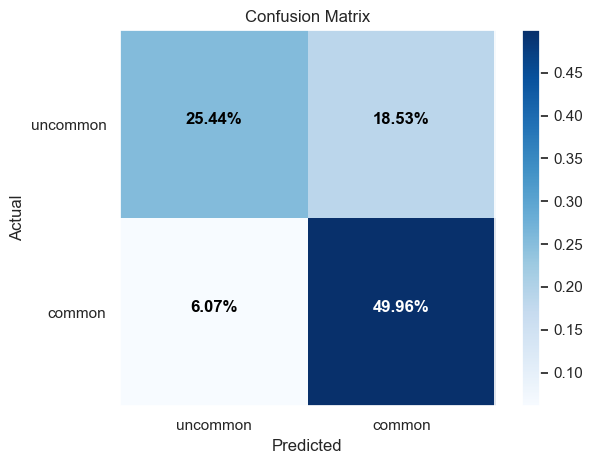

In [25]:
plot_confusion_matrix(y_test, y_pred_test)

We see similar results to the training data, but slightly lower percentages for the correctness of the predictions. We see a total of 75.4% of diagnosis correct, with the remaining 24.6% incorrect. Just under 50% of those correct guesses were for the common diagnosis. We also see a relatively low amount of uncommon predicted diagnosis which were actually common (6.07% False Negative rate). Let's check out the scores now. 

In [26]:
Scores(y_test,y_pred_test)

Accuracy: 0.754
Precision: 0.729
Recall: 0.892
F1: 0.802
Balanced Accuracy: 0.735


With the accuracy, we see 75.4% of the guesses were correct, with similar Precision and Balanced Accuracy scores. The Recall is still higher with the relatively small 6.07% False Negative rate, so we get a solid 89.2% Recall score which also gives us a higher F1 score. Over, this model performed much better than just guessing the mean, so at the moment, this is our best model to use for predictions of a common diagnosis. 

## Modeling - Random Forest<a id='Modeling_RF'></a>

Now let's create a Random Forest model. First we will find the best value for n_estimator. Then we will predict on both the train and test data as before so we can compare the results. 

In [27]:
n_estimator_values = [100, 150, 200]
accuracy_scores = []
for n in n_estimator_values:
    rf_classifier = RandomForestClassifier(n_estimators=n,random_state=42)
    rf_classifier.fit(X_train,y_train)
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
# Find the index of the C value with the highest accuracy
best_index = accuracy_scores.index(max(accuracy_scores))
best_n = n_estimator_values[best_index]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best n_estimator:", best_n)
print("Accuracy:", accuracy)

Best n_estimator: 150
Accuracy: 0.7486712224753227


We see that the best estimator to use for our model is 150, so we will use that as our n_estimator in our Random Forest model. Let's train the model now. 

In [28]:
#Random Forest
rf_classifier = RandomForestClassifier(n_estimators=150, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred_train = rf_classifier.predict(X_train)
y_pred_test = rf_classifier.predict(X_test)

We now have our models created, so let's take a look at the confusion matrix. 

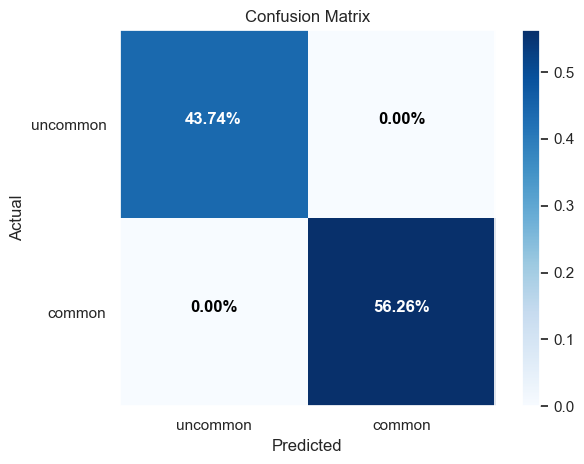

In [29]:
#Train Confusion Matrix
plot_confusion_matrix(y_train, y_pred_train)

With the confusion matrix, we see that we fit the data exactly as 56.26% are common and 43.74% are uncommon types which was exactly what the data had. This makes sense as this is the train data so the system created a model to be able to sort everything with 100% accurately with the Random Forest. Let's take a look at the Scores now. 

In [30]:
Scores(y_train,y_pred_train)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
Balanced Accuracy: 1.0


We see that since we predicted everything correctly, we have 100% scores on every metric. This is expected though because this is the train data with a Random Forest model. The real test will be how it performs with unseen data, so let's take a look at the confusion matrix for the test data. 

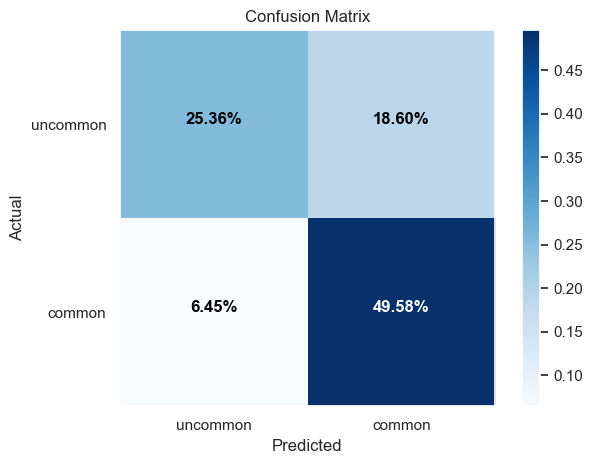

In [31]:
#Test Confusion Matrix
plot_confusion_matrix(y_test, y_pred_test)

With the confusion matrix for the test data, we are no longer perfect as we have 6.45% False Negatives and 18.60% False Positives. This is in line with the Logistic Regression model, so let's take a look at the Scores for this model. 

In [32]:
Scores(y_test,y_pred_test)

Accuracy: 0.749
Precision: 0.727
Recall: 0.885
F1: 0.798
Balanced Accuracy: 0.731


We have slightly lower scores in all metrics when compared to the Logistic Regression Model: Accuracy (.5%), Precision (.2%), Recall (.7%), F1 (.4%), Balanced Accuracy (.4%). This means the models are really close, but the Logistic Regression model slightly edges the Random Forest when using these metrics. Based on all this info, we can conclude that the Logistic Regression model is the better option, but they are so close that it could go either way. 

## Conclusion<a id='Conclusion'></a>

After creating a baseline model and then running a Logistic Regression and Random Forest model, we see that the Logistic Regression has the best prediction among all the models. Most importantly, it is a way better predictor than just guessing the mean each time as it beats out the accuracy by around 19%. Between the Logistic Regression and the Random Forest model, we see slightly better results from the Logistic Regression model, but because the results are so close, it may be worth exploring with Cross Validation which model is truly better, as well as try some additional models. We can also look into creating more features and tune some hyper-parameters to help with the model performance as well. 